In [1]:
import sys
import os
from datetime import datetime
import time
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
pd.set_option('display.max_rows', None)
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
sys.path.append(os.path.abspath('../src'))
from lib import (
    #get_train_test_split,
    #get_trained_model,
    train_and_evaluate_models,
    create_eui_comparison_plots,
    evaluate_model_strategies,
    calculate_average_metrics,
    create_error_distribution_plots
)

In [3]:
output_path = "../data/03_processed/merged_df.csv"
merged_df = pd.read_csv(output_path)
merged_df = merged_df.rename(columns={'total_year': 'hdd_total_year'})

# GDP per capita
merged_df['GDP_per_capita'] = merged_df['GDP_2022'] / merged_df['Population_2023']

# Delete Taiwan (temporal)
merged_df = merged_df[merged_df['Country'] != 'Taiwan']

np.random.seed(123)
merged_df['is_train'] = np.random.choice([1, 0], size=len(merged_df), p=[0.8, 0.2])

In [4]:
features = [
    "hdd_total_year", 
    "cdd_total_year", 
    "GDP_per_capita", 
    "Urbanization_Rate_2022",
    "latitude",
    "longitude",  
    "Paris_Agreement",
    "Subnational HDI", 
    "Educational index", 
    "Income index"
]

feature_abbreviations = {
    "hdd_total_year": "HDD",
    "cdd_total_year": "CDD", 
    "GDP_per_capita": "GDP",
    "Urbanization_Rate_2022": "URB",
    "latitude": "Lat",
    "longitude": "Long",
    "Paris_Agreement": "Paris",
    "Subnational HDI": "HDI", 
    "Educational index": "EDU" , 
    "Income index": "Income"
}

target_columns = [
    "Residential EUI (kWh/m2/year)",
    "Non-residential EUI (kWh/m2/year)"
]

regions = ['Asia & Oceania', 'Europe', 'Africa', 'Central and South America', 'Northern America']


# Linear Regression (Base Line Model) 

### Linear Regression (Base Line Model) - Within Domain

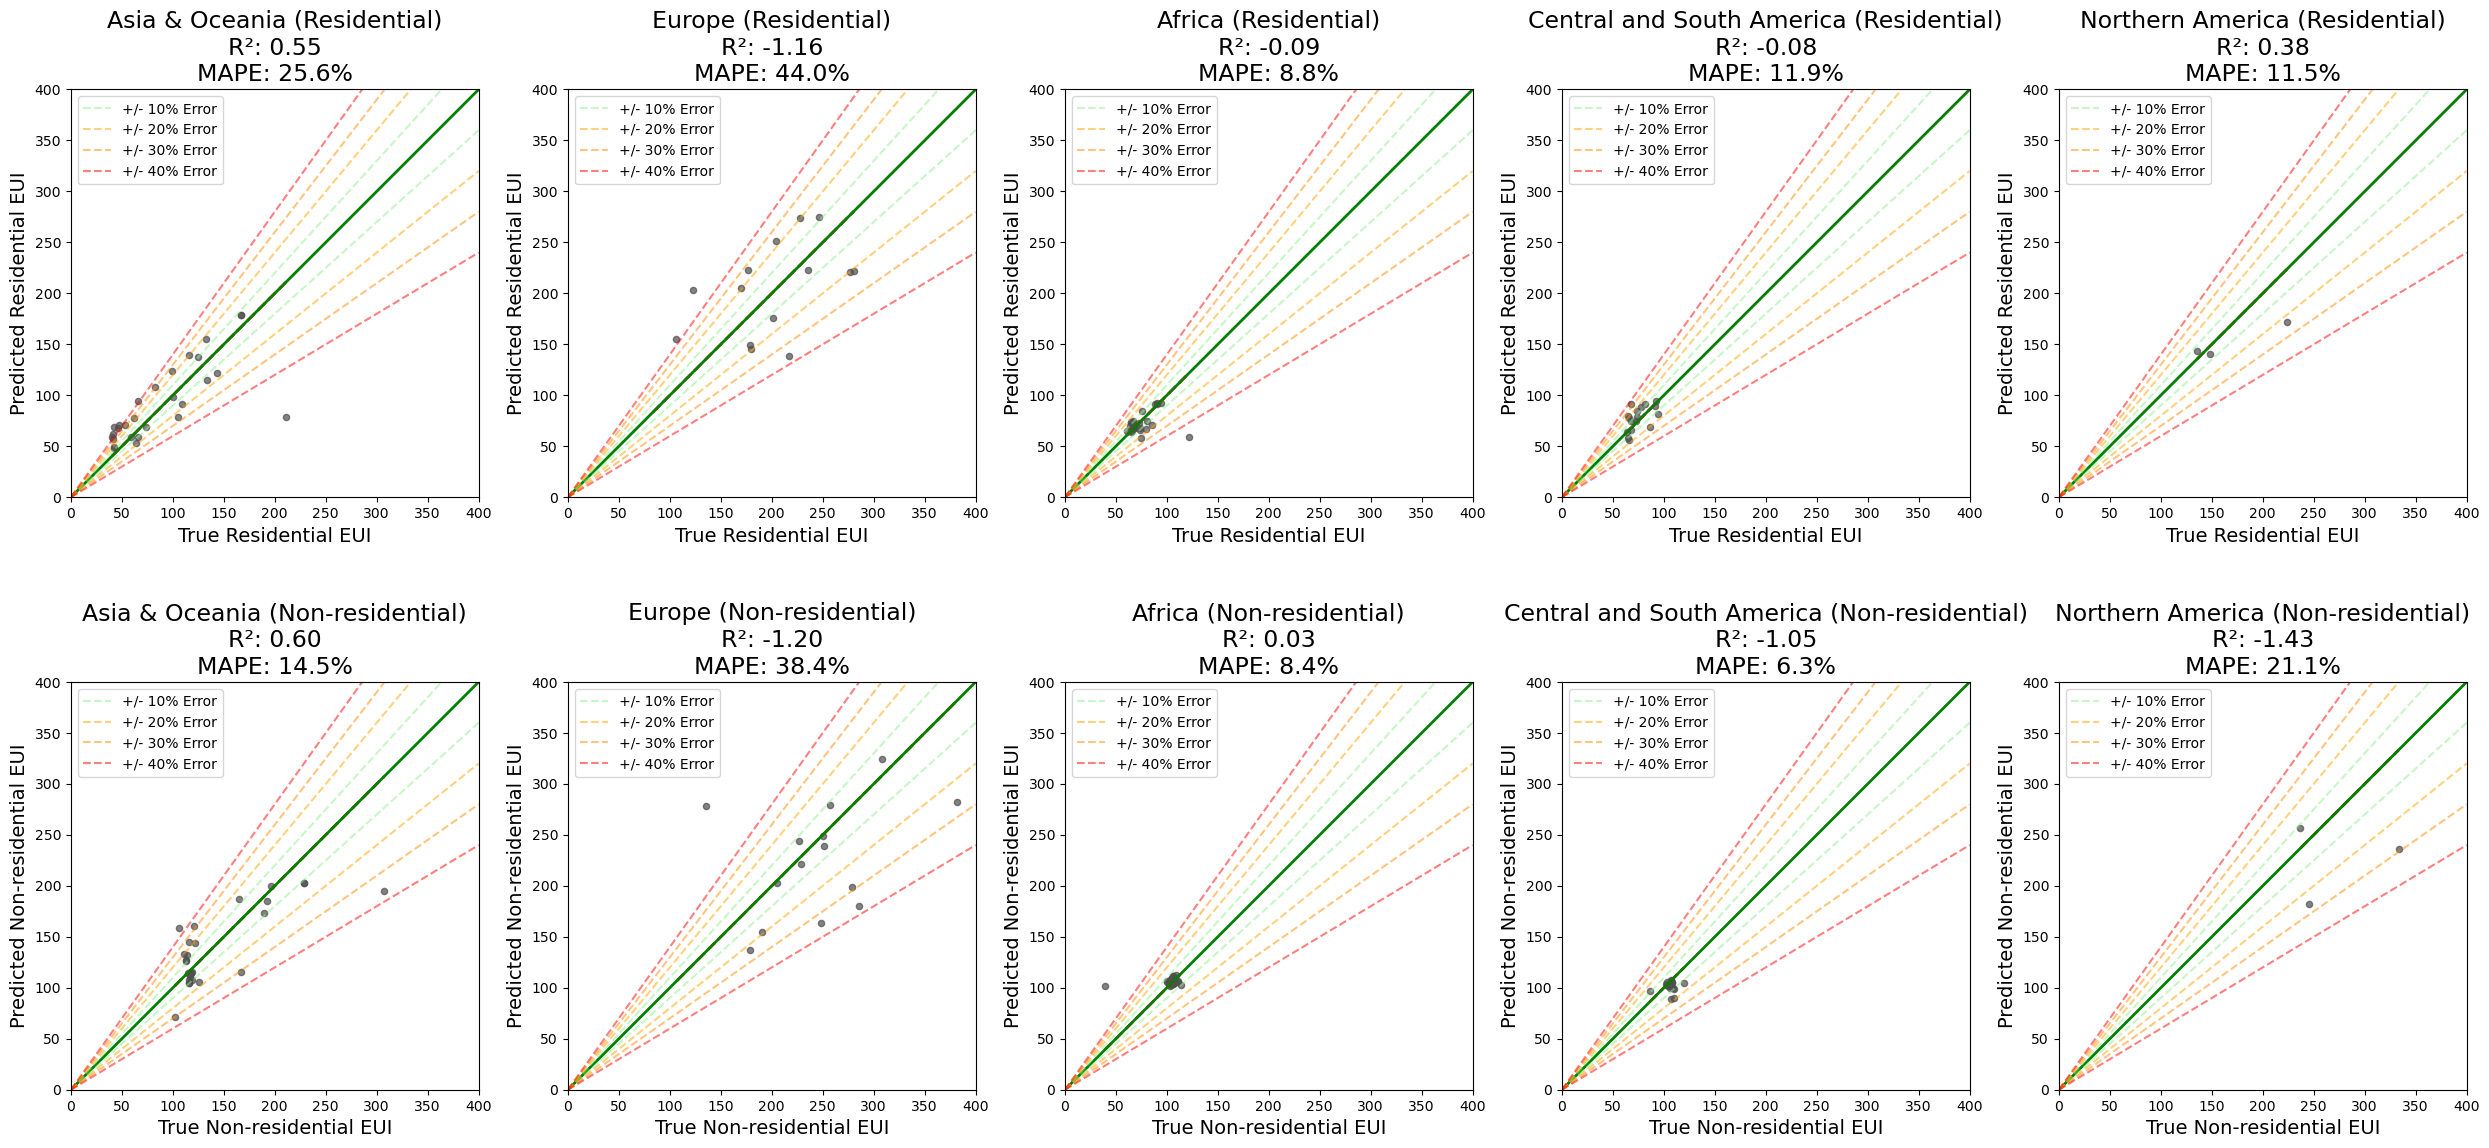

In [5]:
# Within-domain
model_lr_within = LinearRegression()
results_lr_within = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions, 
    features=features,
    model=model_lr_within,
    strategy='within_domain'
)

create_eui_comparison_plots(results_lr_within, 
    save_path='../figures/model_plots/lr_within_domain_eui_predictions.png')


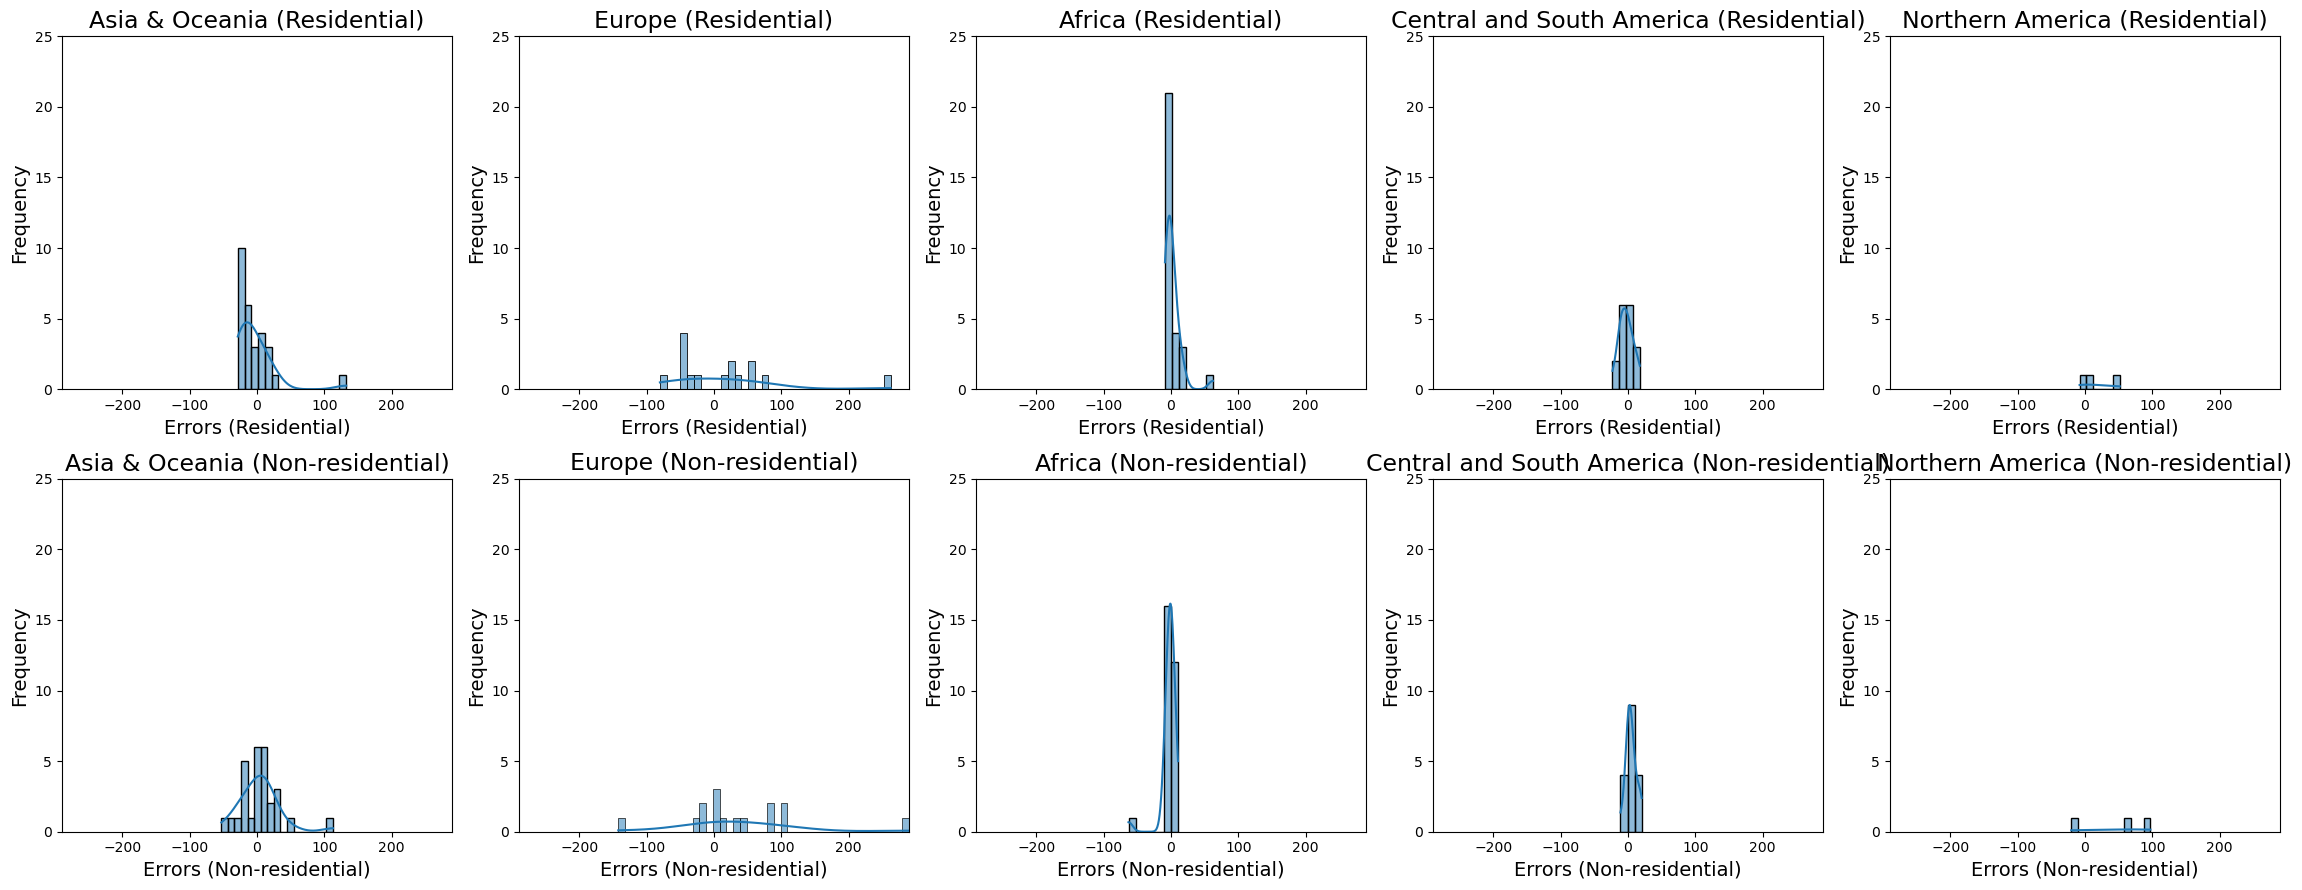

In [6]:
create_error_distribution_plots(results_lr_within,
    save_path='../figures/model_plots/lr_within_domain_error_distribution.png')

### Linear Regression (Base Line Model) - Cross Domain

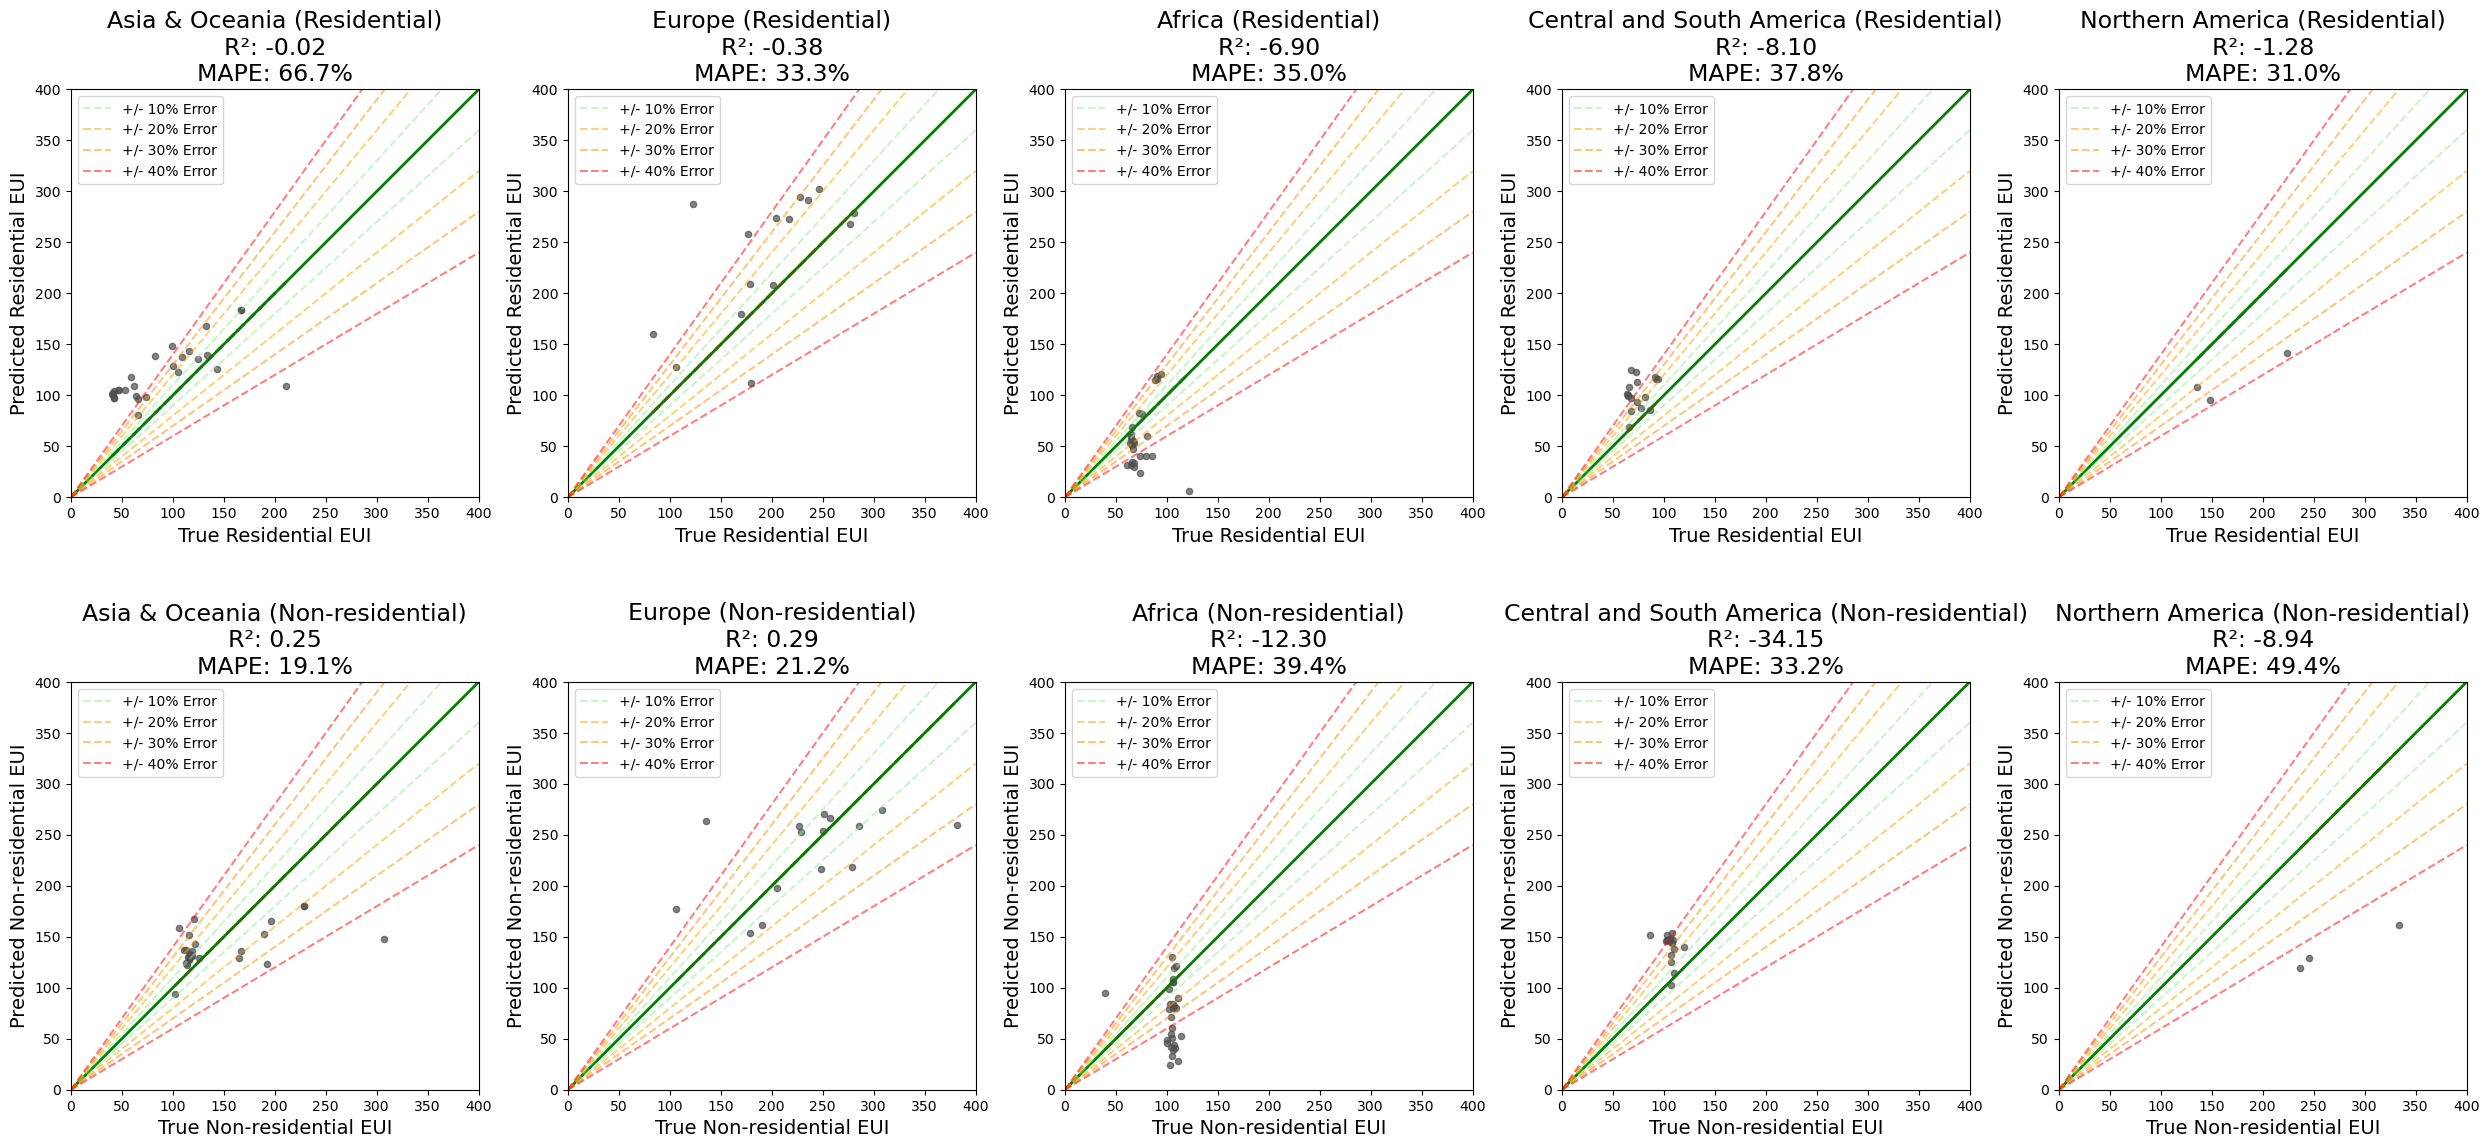

In [7]:
# Cross-domain 
model_lr_cross = LinearRegression()
results_lr_cross = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features, 
    model=model_lr_cross,
    strategy='cross_domain'
)

create_eui_comparison_plots(results_lr_cross,
    save_path='../figures/model_plots/lr_cross_domain_eui_predictions.png')

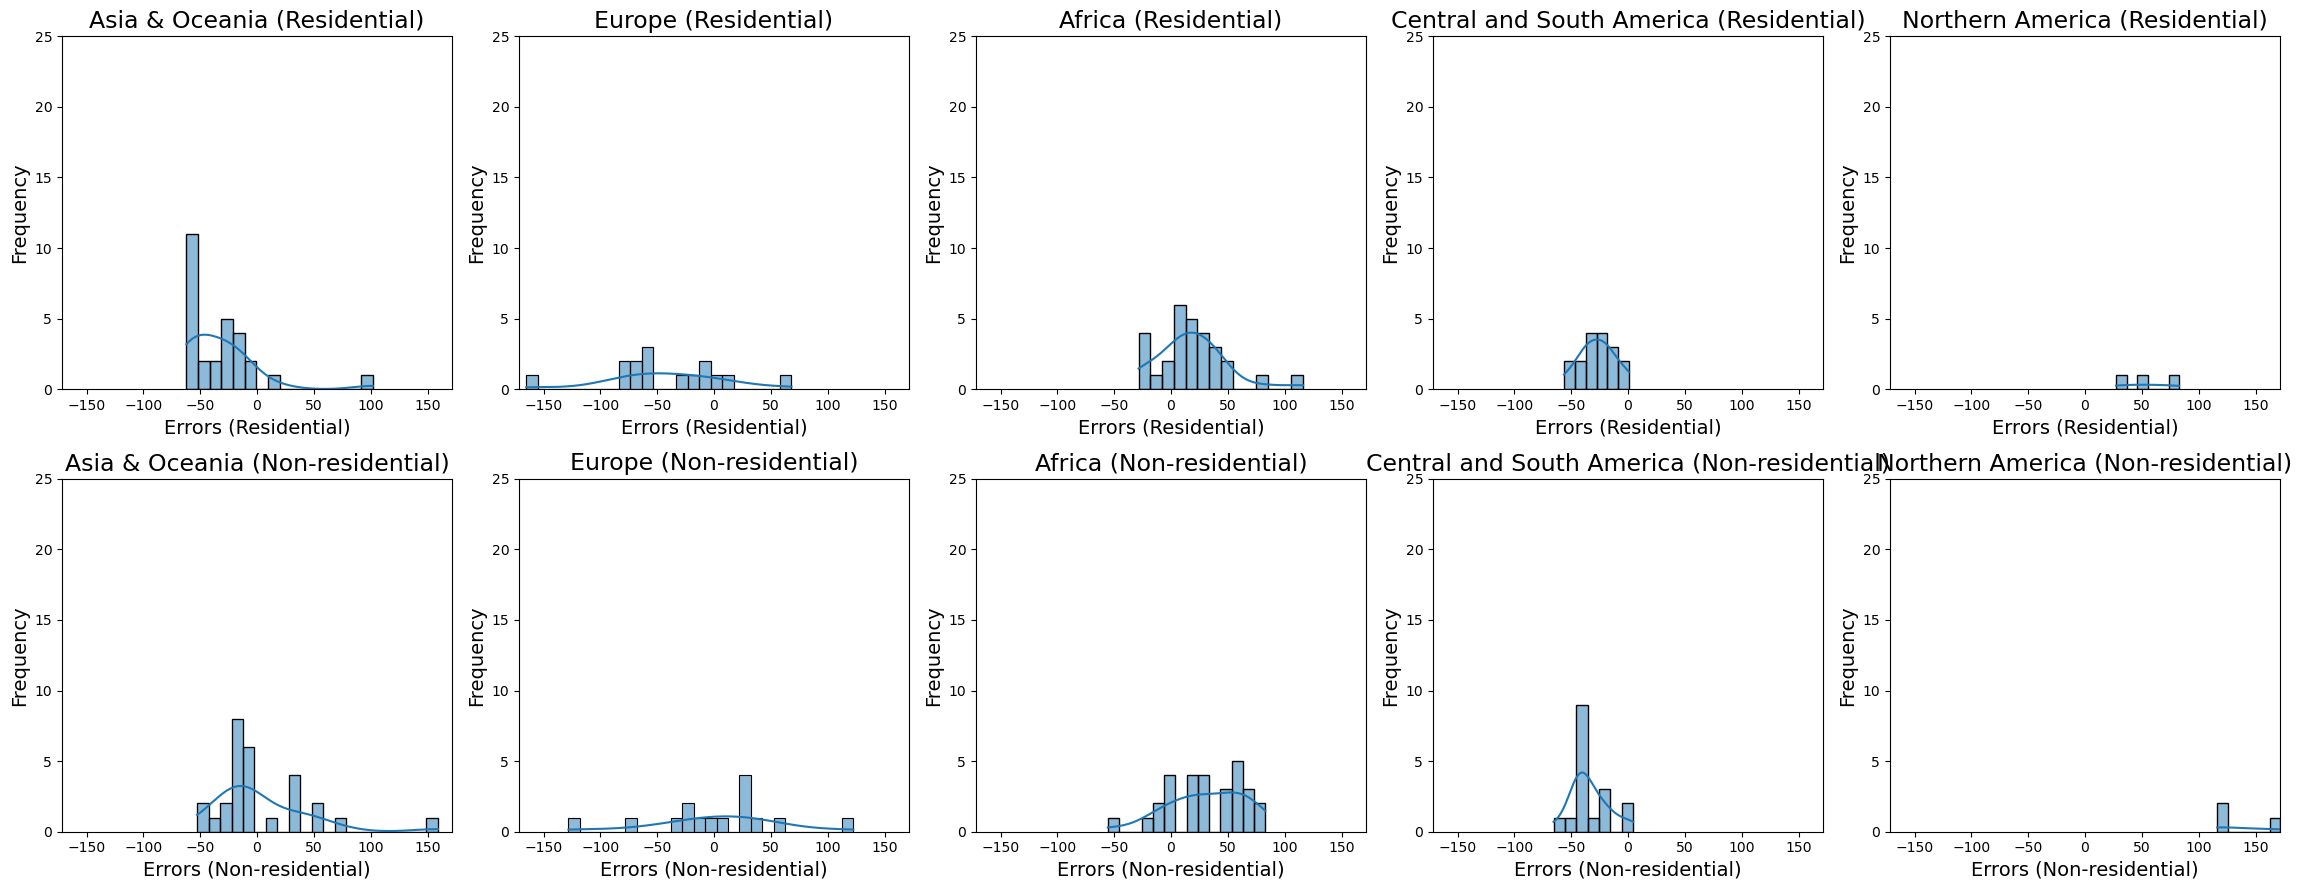

In [8]:
create_error_distribution_plots(results_lr_cross,
    save_path='../figures/model_plots/lr_cross_domain_error_distribution.png')

### Linear Regression (Base Line Model) - All Domain

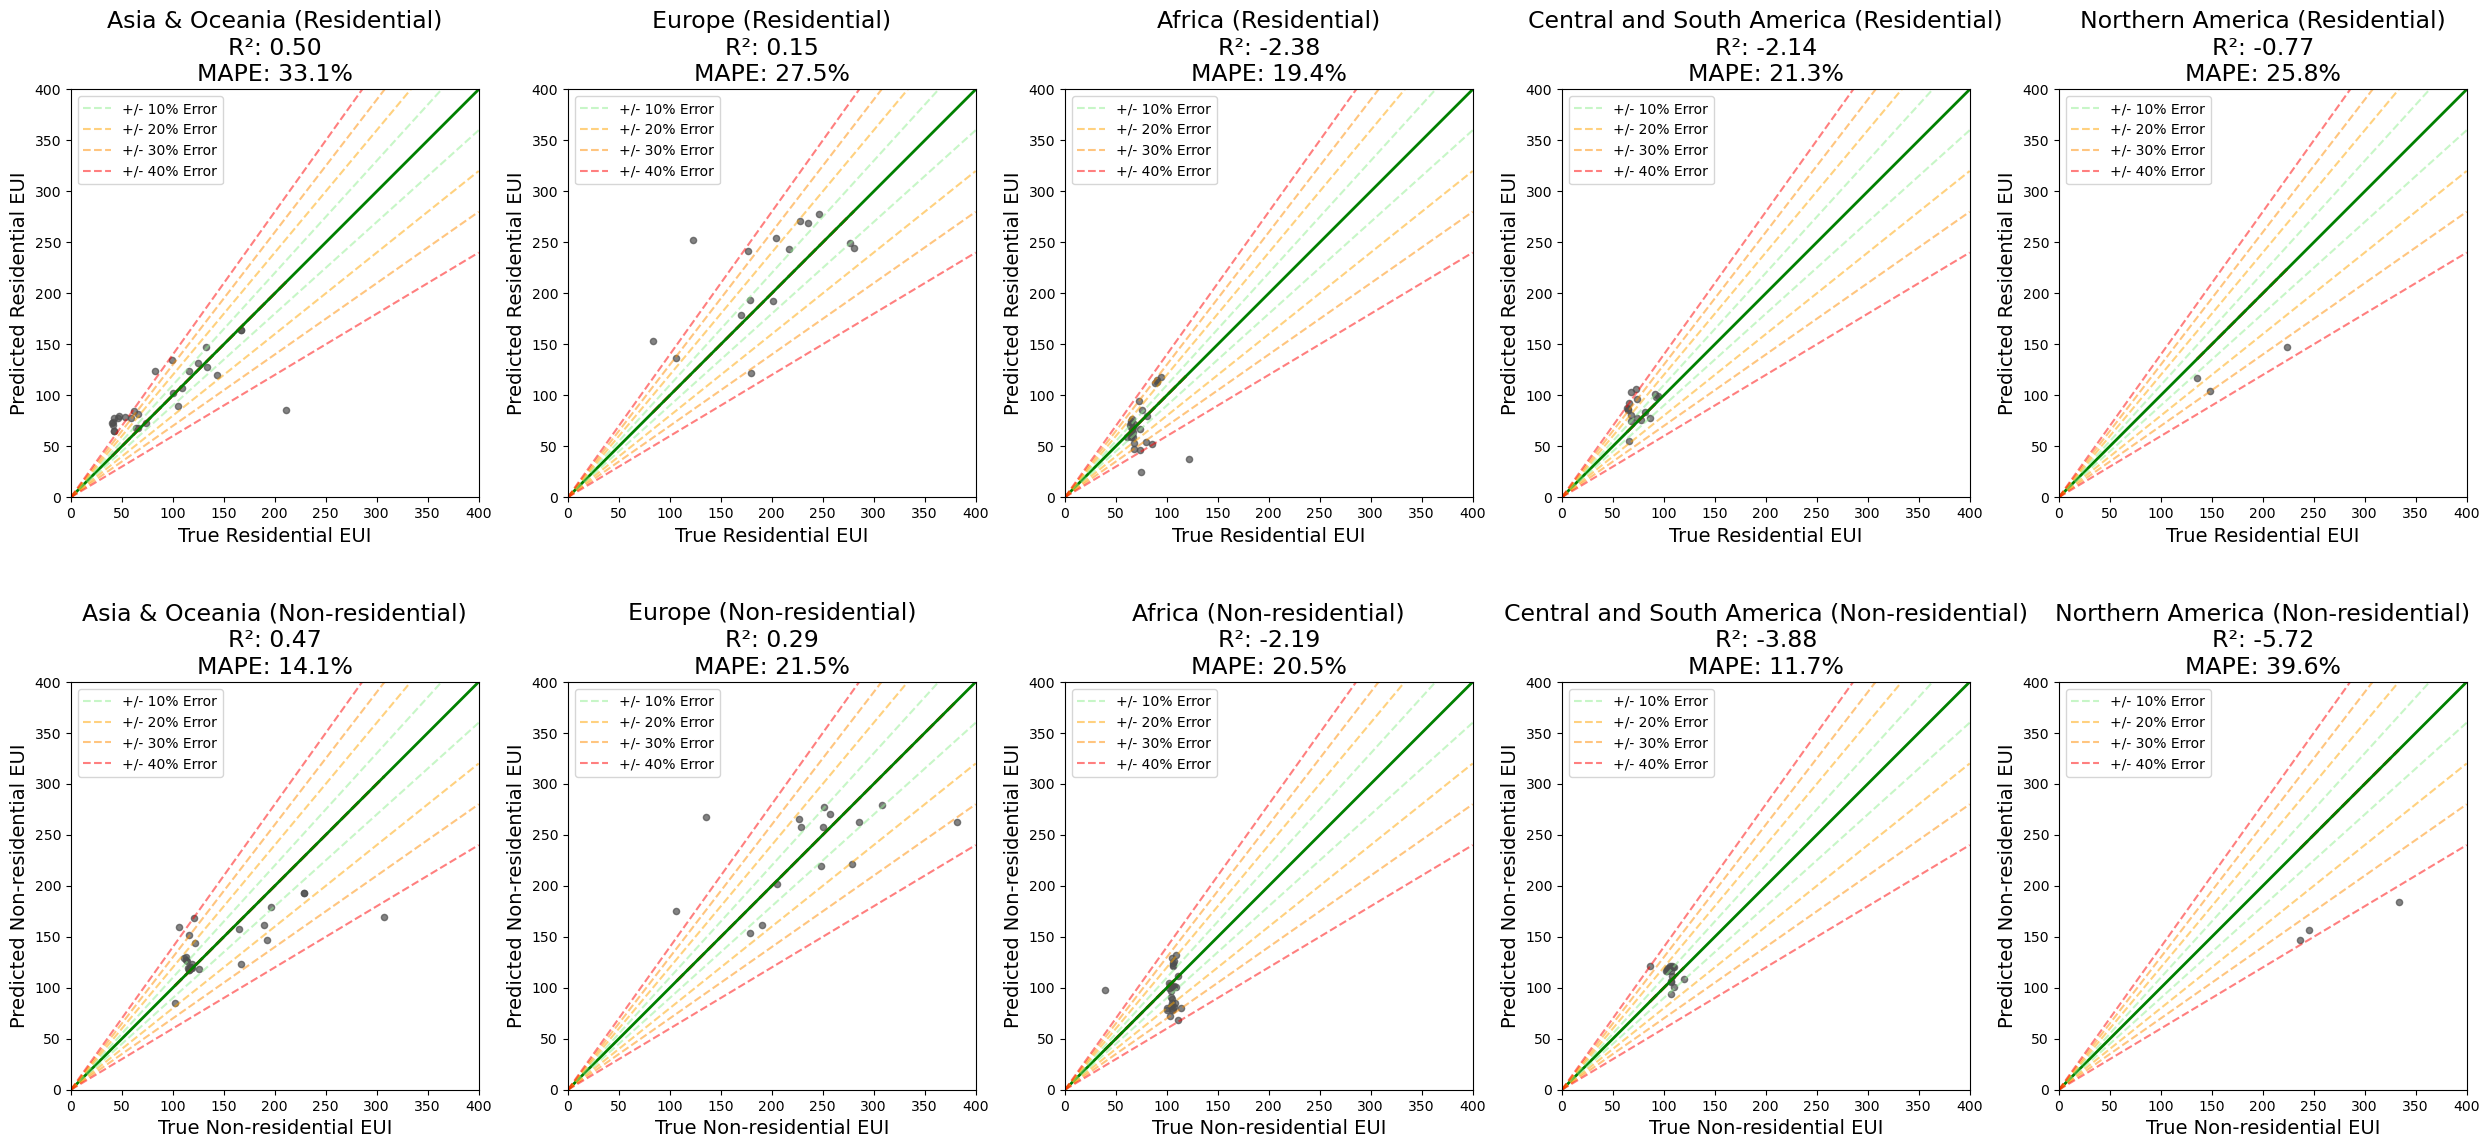

In [9]:
# All-domain
model_lr_all = LinearRegression()
results_lr_all = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_lr_all, 
    strategy='all_domain'
)

create_eui_comparison_plots(results_lr_all,
    save_path='../figures/model_plots/lr_all_domain_eui_predictions.png')

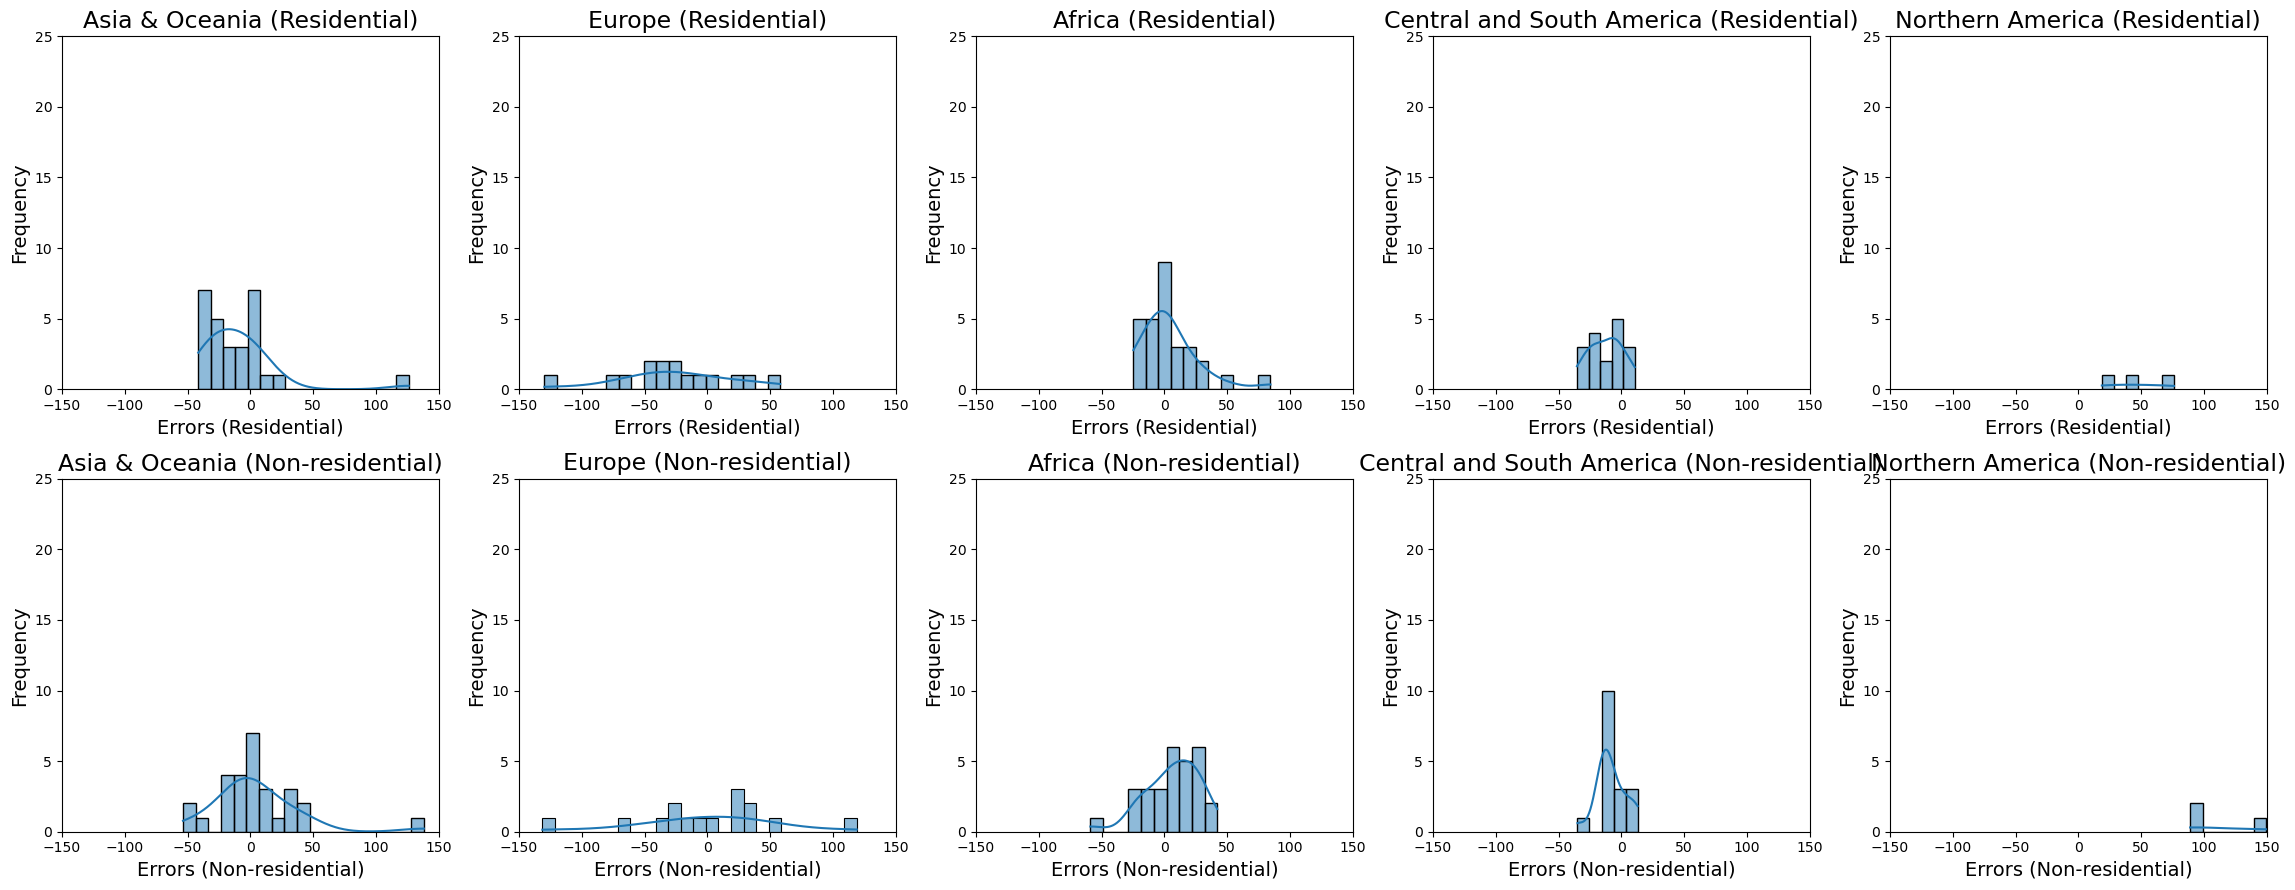

In [10]:
create_error_distribution_plots(results_lr_all,
    save_path='../figures/model_plots/lr_all_domain_error_distribution.png')

In [11]:
lr_detailed_results = evaluate_model_strategies(
   merged_df=merged_df,
   regions=regions,
   features=features,
   model_type=LinearRegression,
   feature_abbreviations=feature_abbreviations,
   model_details="No regularization"
)

lr_average_results = calculate_average_metrics(lr_detailed_results).reset_index()
lr_average_results

,Target,Strategy,Model,Model Details,Features Used,Features Abbreviated,MAPE,R²,MSE,RMSE,MAE,WAPE
0,Non-residential EUI (kWh/m2/year),within_domain,LinearRegression,No regularization,"hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,17.74,-0.608,3067.807,43.550,31.453,15.10
1,Non-residential EUI (kWh/m2/year),cross_domain,LinearRegression,No regularization,"hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,32.46,-10.973,5459.066,63.754,55.872,31.58
2,Non-residential EUI (kWh/m2/year),all_domain,LinearRegression,No regularization,"hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,21.48,-2.206,3565.130,48.102,40.779,20.50
3,Residential EUI (kWh/m2/year),within_domain,LinearRegression,No regularization,"hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,20.36,-0.079,1793.940,33.577,23.675,17.70
4,Residential EUI (kWh/m2/year),cross_domain,LinearRegression,No regularization,"hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,40.76,-3.336,2443.346,47.638,40.339,35.64
5,Residential EUI (kWh/m2/year),all_domain,LinearRegression,No regularization,"hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,25.42,-0.926,1458.517,35.534,28.291,23.08


In [12]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
lr_detailed_results.to_csv(f'../results/{timestamp}_lr_detailed_results.csv')
lr_average_results.to_csv(f'../results/{timestamp}_lr_average_results.csv')

# 